# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, datasets, transforms
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("data/")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path("models/")
MODELS_DIR.mkdir(exist_ok=True)
COLAB_DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/ML")

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [6]:
# полезные полезности из этой и предыдущих частей

def is_colab() -> bool:
    return DEVICE == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        verbose: int = 100,
        test_dataloader: DataLoader = None,
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose)
        train_losses.append(train_loss.item())
        if test_dataloader:
            test_loop(test_dataloader, model, loss_fn)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


class FastDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

        n = len(self.dataset)
        x, _ = self.dataset[0]
        self._data = torch.empty(n, *x.size(), dtype=x.dtype)
        self._targets = [0] * n
        for i, (x, y) in tqdm(enumerate(self.dataset), total=n):
            self._data[i] = x
            self._targets[i] = y

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self._data[idx], self._targets[idx]


def plot_losses(losses):
    plt.plot(torch.arange(len(losses)), losses)


def _color_imshow(img):
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1))


def _gray_imshow(img):
    plt.imshow(img.squeeze(), cmap="gray")


def visualize_predicts(
        model: nn.Module,
        dataset: Dataset,
        classes,
        cols: int = 4,
        rows: int = 4,
        figsize=(10, 11),
        imshow=_color_imshow,
):
    model.eval()

    fig = plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()  # noqa
        img, true_label = dataset[sample_idx]

        pred = model(img.unsqueeze(0).to(DEVICE))
        pred_proba = F.softmax(pred, 1).max(1).values.item()
        pred_label = pred.argmax(1).item()

        fig.add_subplot(rows, cols, i)
        plt.title(
            f"pred: {classes[pred_label]} ({pred_proba:.2f})"
            f"\ntrue: {classes[true_label]}", loc="left"
        )
        plt.axis("off")
        imshow(img.cpu())


def plot_confusion_matrix(y_true, y_pred, classes):
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=classes,
        xticks_rotation=45,
        cmap=sns.color_palette("light:b", as_cmap=True),
        colorbar=False,
    )
    cm_display.ax_.grid(False)
    cm_display.figure_.set_size_inches(4.5, 4.5)


def get_y_test_y_pred_batches(model: nn.Module, test_dataloader: DataLoader):
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [8]:
if is_colab():
    from google.colab import drive

    drive.mount('/content/drive')
    !cp -r "/content/drive/MyDrive/Colab Notebooks/ML/monkeys" "/content/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C


In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/training/training",
    transform=transform,
)
test_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/validation/validation",
    transform=transform,
)

(
    (len(train_monkeys_dataset), len(test_monkeys_dataset)),
    train_monkeys_dataset[0][0].shape,
    len(train_monkeys_dataset.classes),
)

((1097, 272), torch.Size([3, 224, 224]), 10)

In [ ]:
fast_train_monkeys_dataset = FastDataset(train_monkeys_dataset)
fast_test_monkeys_dataset = FastDataset(test_monkeys_dataset)

100%|██████████| 272/272 [00:08<00:00, 32.32it/s]


In [ ]:
class MonkeysVGG16(nn.Module):

    def __init__(self):
        super(MonkeysVGG16, self).__init__()
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.vgg16.classifier[-1] = nn.Linear(self.vgg16.classifier[-1].in_features, 10)

    def forward(self, x):
        return self.vgg16(x)

In [ ]:
torch.manual_seed(0)

net = MonkeysVGG16().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

monkeys_train_dataloader = DataLoader(
    fast_train_monkeys_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2 if is_colab() else 0,
)
monkeys_test_dataloader = DataLoader(
    fast_test_monkeys_dataset,
    batch_size=256,
    num_workers=2 if is_colab() else 0,
)

net

MonkeysVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [ ]:
%%time
# дообучение всей модели

train_losses_1 = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=monkeys_train_dataloader,
    epochs=20,
    verbose=50,
    test_dataloader=monkeys_test_dataloader,
)

Epoch 1
--------------------------------
loss: 2.323372  [    0/ 1097]
loss: 2.337447  [  400/ 1097]
loss: 2.275961  [  800/ 1097]
Test Error: 
 Accuracy: 0.161765, Avg loss: 2.284286 

Epoch 2
--------------------------------
loss: 2.306798  [    0/ 1097]
loss: 2.333511  [  400/ 1097]
loss: 2.235263  [  800/ 1097]
Test Error: 
 Accuracy: 0.283088, Avg loss: 2.164592 

Epoch 3
--------------------------------
loss: 2.105698  [    0/ 1097]
loss: 2.296935  [  400/ 1097]
loss: 2.158214  [  800/ 1097]
Test Error: 
 Accuracy: 0.205882, Avg loss: 2.127714 

Epoch 4
--------------------------------
loss: 1.498314  [    0/ 1097]
loss: 1.979490  [  400/ 1097]
loss: 1.648932  [  800/ 1097]
Test Error: 
 Accuracy: 0.375000, Avg loss: 1.872794 

Epoch 5
--------------------------------
loss: 1.845105  [    0/ 1097]
loss: 1.737956  [  400/ 1097]
loss: 1.905373  [  800/ 1097]
Test Error: 
 Accuracy: 0.341912, Avg loss: 1.839215 

Epoch 6
--------------------------------
loss: 1.816044  [    0/ 1097]

In [ ]:
%%time
# дообучение классификатора

for p in net.vgg16.features.parameters():
    p.requires_grad = False  # замороженные слои не участвуют в расчете градиента

# оптимизатор не будет обновлять параметры замороженных слоев
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)

train_losses_2 = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=monkeys_train_dataloader,
    epochs=20,
    verbose=50,
    test_dataloader=monkeys_test_dataloader,
)

Epoch 1
--------------------------------
loss: 0.176703  [    0/ 1097]
loss: 0.725086  [  400/ 1097]
loss: 0.367887  [  800/ 1097]
Test Error: 
 Accuracy: 0.632353, Avg loss: 1.199234 

Epoch 2
--------------------------------
loss: 0.256760  [    0/ 1097]
loss: 0.024024  [  400/ 1097]
loss: 0.230608  [  800/ 1097]
Test Error: 
 Accuracy: 0.698529, Avg loss: 1.160318 

Epoch 3
--------------------------------
loss: 0.169549  [    0/ 1097]
loss: 0.014666  [  400/ 1097]
loss: 0.152395  [  800/ 1097]
Test Error: 
 Accuracy: 0.680147, Avg loss: 1.157102 

Epoch 4
--------------------------------
loss: 0.085385  [    0/ 1097]
loss: 0.163768  [  400/ 1097]
loss: 0.247606  [  800/ 1097]
Test Error: 
 Accuracy: 0.698529, Avg loss: 1.165361 

Epoch 5
--------------------------------
loss: 0.016058  [    0/ 1097]
loss: 0.014888  [  400/ 1097]
loss: 0.023950  [  800/ 1097]
Test Error: 
 Accuracy: 0.676471, Avg loss: 1.294171 

Epoch 6
--------------------------------
loss: 0.039735  [    0/ 1097]

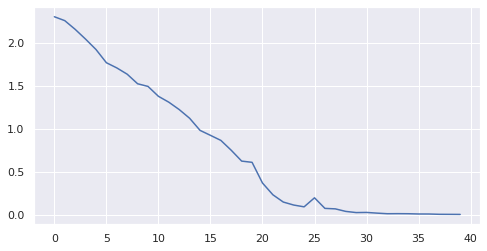

In [ ]:
plot_losses([*train_losses_1, *train_losses_2]);

In [ ]:
y_test, y_pred = get_y_test_y_pred_batches(
    model=net,
    test_dataloader=monkeys_test_dataloader,
)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=test_monkeys_dataset.classes,
))

              precision    recall  f1-score   support

          n0       0.65      0.65      0.65        26
          n1       0.57      0.71      0.63        28
          n2       0.87      0.96      0.91        27
          n3       0.78      0.83      0.81        30
          n4       0.61      0.42      0.50        26
          n5       0.61      0.50      0.55        28
          n6       0.68      0.73      0.70        26
          n7       0.76      0.57      0.65        28
          n8       0.79      0.81      0.80        27
          n9       0.61      0.73      0.67        26

    accuracy                           0.69       272
   macro avg       0.69      0.69      0.69       272
weighted avg       0.69      0.69      0.69       272



### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [9]:
if is_colab():
    from google.colab import drive

    drive.mount('/content/drive')
    !cp -r "/content/drive/MyDrive/Colab Notebooks/ML/cats_dogs" "/content/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

cats_dogs_dataset = datasets.ImageFolder(
    DATA_DIR / "cats_dogs/cats_dogs/train",
    transform=transform,
)

train_size = round(0.8 * len(cats_dogs_dataset))
train_cats_dogs_dataset, test_cats_dogs_dataset = random_split(
    cats_dogs_dataset,
    lengths=(train_size, len(cats_dogs_dataset) - train_size),
)

(
    (len(train_cats_dogs_dataset), len(test_cats_dogs_dataset)),
    train_cats_dogs_dataset[0][0].shape,
    len(cats_dogs_dataset.classes),
)

((20018, 5005), torch.Size([3, 224, 224]), 2)

In [11]:
class CatsDogsResnet34(nn.Module):

    def __init__(self):
        super(CatsDogsResnet34, self).__init__()
        self.resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.resnet34.fc = nn.Linear(self.resnet34.fc.in_features, 2)

    def forward(self, x):
        return self.resnet34(x)

In [12]:
torch.manual_seed(0)

net = CatsDogsResnet34().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

cats_dogs_train_dataloader = DataLoader(
    train_cats_dogs_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2 if is_colab() else 0,
)
cats_dogs_test_dataloader = DataLoader(
    test_cats_dogs_dataset,
    batch_size=256,
    num_workers=2 if is_colab() else 0,
)

net

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

CatsDogsResnet34(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [13]:
%%time

train_losses_1 = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=cats_dogs_train_dataloader,
    epochs=5,
    verbose=50,
    test_dataloader=cats_dogs_test_dataloader,
)

Epoch 1
--------------------------------
loss: 0.903646  [    0/20018]
loss: 0.116964  [ 6400/20018]
loss: 0.166791  [12800/20018]
loss: 0.054015  [19200/20018]
Test Error: 
 Accuracy: 0.950450, Avg loss: 0.126979 

Epoch 2
--------------------------------
loss: 0.081613  [    0/20018]
loss: 0.054190  [ 6400/20018]
loss: 0.065505  [12800/20018]
loss: 0.069936  [19200/20018]
Test Error: 
 Accuracy: 0.941658, Avg loss: 0.147875 

Epoch 3
--------------------------------
loss: 0.060484  [    0/20018]
loss: 0.038992  [ 6400/20018]
loss: 0.016320  [12800/20018]
loss: 0.071716  [19200/20018]
Test Error: 
 Accuracy: 0.963636, Avg loss: 0.091553 

Epoch 4
--------------------------------
loss: 0.014432  [    0/20018]
loss: 0.026906  [ 6400/20018]
loss: 0.087867  [12800/20018]
loss: 0.061886  [19200/20018]
Test Error: 
 Accuracy: 0.956643, Avg loss: 0.130082 

Epoch 5
--------------------------------
loss: 0.021375  [    0/20018]
loss: 0.033910  [ 6400/20018]
loss: 0.039884  [12800/20018]
loss:

In [14]:
%%time

for p in net.parameters():
    p.requires_grad = False

for p in net.resnet34.fc.parameters():
    p.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

train_losses_2 = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=cats_dogs_train_dataloader,
    epochs=10,
    verbose=50,
    test_dataloader=cats_dogs_test_dataloader,
)

Epoch 1
--------------------------------
loss: 0.003980  [    0/20018]
loss: 0.037054  [ 6400/20018]
loss: 0.048091  [12800/20018]
loss: 0.029684  [19200/20018]
Test Error: 
 Accuracy: 0.973626, Avg loss: 0.089744 

Epoch 2
--------------------------------
loss: 0.016831  [    0/20018]
loss: 0.055183  [ 6400/20018]
loss: 0.043777  [12800/20018]
loss: 0.033879  [19200/20018]
Test Error: 
 Accuracy: 0.973427, Avg loss: 0.089307 

Epoch 3
--------------------------------
loss: 0.066278  [    0/20018]
loss: 0.035228  [ 6400/20018]
loss: 0.010558  [12800/20018]
loss: 0.017651  [19200/20018]
Test Error: 
 Accuracy: 0.973826, Avg loss: 0.087870 

Epoch 4
--------------------------------
loss: 0.038997  [    0/20018]
loss: 0.015885  [ 6400/20018]
loss: 0.026898  [12800/20018]
loss: 0.007291  [19200/20018]
Test Error: 
 Accuracy: 0.973227, Avg loss: 0.095144 

Epoch 5
--------------------------------
loss: 0.006811  [    0/20018]
loss: 0.005046  [ 6400/20018]
loss: 0.035352  [12800/20018]
loss:

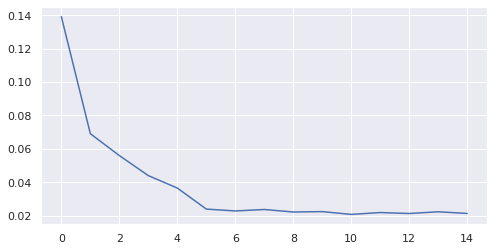

In [15]:
plot_losses([*train_losses_1, *train_losses_2]);

In [16]:
y_test, y_pred = get_y_test_y_pred_batches(
    model=net,
    test_dataloader=cats_dogs_test_dataloader,
)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=cats_dogs_dataset.classes,
))

              precision    recall  f1-score   support

         cat       0.98      0.97      0.97      2583
         dog       0.97      0.98      0.97      2422

    accuracy                           0.97      5005
   macro avg       0.97      0.97      0.97      5005
weighted avg       0.97      0.97      0.97      5005

